# Properly inferring the mode frequencies from the data

I'm having issues with a more complex model for the asymptotic relation, so I'm going to start at the absolute bare-bones basics and go from there.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns
import mystyle as ms

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

from utils import *

import pymc3 as pm
import arviz

In [2]:
target = 3632418
f, p, ff, pp, star, modelocs, elocs, modeids, overtones = read_data(target, 12, 33)

In [3]:
kic = star.KIC
dnu_ = star.dnu
numax_ = star.numax

In [4]:
backdir = glob.glob('/home/oliver/PhD/mnt/RDS/malatium/backfit/'
                +str(kic)+'/*_fit.pkl')[0]
with open(backdir, 'rb') as file:
    backfit = pickle.load(file)

labels=['loga','logb','logc','logd','logj','logk','white','scale','nyq']
res = np.array([np.median(backfit[label]) for label in labels])
res[0:6] = 10**res[0:6]

phi_ = np.array([np.median(backfit[label]) for label in labels])
phi_sigma = pd.DataFrame(backfit)[labels].cov()
phi_cholesky = np.linalg.cholesky(phi_sigma)

mm = get_background(ff, *res)
m = get_background(f, *res)
p /= m
pp /= mm

In [5]:
# Read in the fit data
cad = pd.read_csv('../../data/cadmium.csv', index_col=0)
cad = cad.loc[cad.KIC == target]

(0, 50)

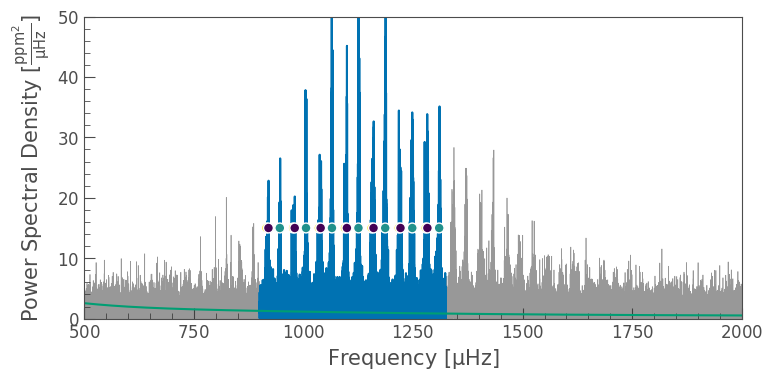

In [6]:
pg = lk.Periodogram(ff*u.microhertz, pp*(cds.ppm**2 / u.microhertz))
ax = pg.plot(alpha=.5)
ax.plot(f, p)
ax.plot(ff, mm)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=50, edgecolor='w',zorder=100)
ax.set_xlim(500,2000)
ax.set_ylim(0, 50)

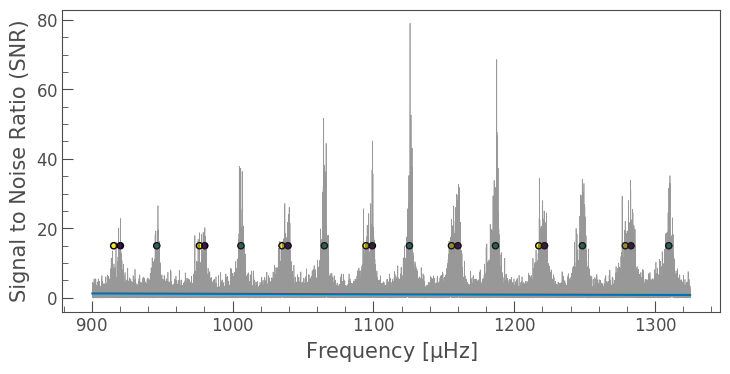

In [7]:
pg = lk.periodogram.SNRPeriodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
# pg.smooth(filter_width=3.).plot(ax=ax, linewidth=2)
ax.plot(f, m)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=20, edgecolor='k')
plt.show()

## Build the model

In [8]:
class model():
    def __init__(self, f, n0, n1, n2, f0_, f1_, f2_):
        self.f = f
        self.n0 = n0
        self.n1 = n1
        self.n2 = n2
        self.npts = len(f)
        self.M = [len(f0_), len(f1_), len(f2_)]
        
    def epsilon(self, i, l, m):
    #We use the prescriptions from Gizon & Solanki 2003 and Handberg & Campante 2012
        if l == 0:
            return 1
        if l == 1:
            if m == 0:
                return np.cos(i)**2
            if np.abs(m) == 1:
                return 0.5 * np.sin(i)**2
        if l == 2:
            if m == 0:
                return 0.25 * (3 * np.cos(i)**2 - 1)**2
            if np.abs(m) ==1:
                return (3/8)*np.sin(2*i)**2
            if np.abs(m) == 2:
                return (3/8) * np.sin(i)**4
        if l == 3:
            if m == 0:
                return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
            if np.abs(m) == 1:
                return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
            if np.abs(m) == 2:
                return (15/8) * np.cos(i)**2 * np.sin(i)**4
            if np.abs(m) == 3:
                return (5/16)*np.sin(i)**6
        
    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, i, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * self.epsilon(i, l, m), 
                                     ws[idx])
  
    def model(self, p):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b = p
               
        # Calculate the modes
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, i)
        self.mode(1, f1, h1, g1, i, split)
        self.mode(2, f2, h2, g2, i, split)
               
        #Create the model
        self.mod = self.modes + b
        return self.mod

    def asymptotic(self, n, deltanu, epsilon):       
        over = (n + epsilon)
        return over * deltanu
    
    def f0(self, p):
        deltanu, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, deltanu, epsilon)
    
    def f1(self, p):
        deltanu, epsilon, d01, d02 = p
        
        f0 = self.asymptotic(self.n1, deltanu, epsilon)
        return f0 + d01
    
    def f2(self, p):
        deltanu, epsilon, d01, d02 = p
        
        f0 = self.asymptotic(self.n2+1, deltanu, epsilon)
        return f0 - d02

In [9]:
f0_ = modelocs[modeids==0]
f1_ = modelocs[modeids==1]
f2_ = modelocs[modeids==2]
f0_e = elocs[modeids==0]
f1_e = elocs[modeids==1]
f2_e = elocs[modeids==2]
n0 = overtones[modeids==0]
n1 = overtones[modeids==1]
n2 = overtones[modeids==2]

epsilon_ = cad.epsilon.values[0]
epsilon_e = cad.e_epsilon.values[0]
d01_ = cad.d01.values[0]
d01_e = cad.e_d01.values[0]
d02_ = cad.d02.values[0]
d02_e = cad.e_d02.values[0]
deltanu_ = star.dnu
deltanu_e = star.ednu

Do some first guesses for height

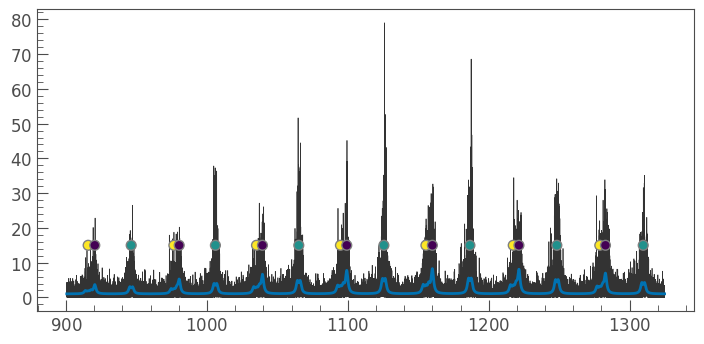

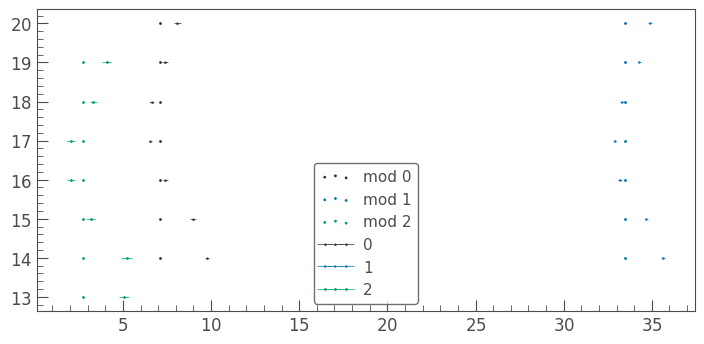

In [10]:
init_m =[f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       np.ones(len(f0_)) * 2.0,     # l0 widths
       np.ones(len(f1_)) * 2.0,     # l1 widths
       np.ones(len(f2_)) * 2.0,     # l2 widths
       np.sqrt(gaussian(f0_, 0, numax_, 15.) * 2.0 * np.pi / 2.0) ,# l0 heights
       np.sqrt(gaussian(f1_, 1, numax_, 15.) * 2.0 * np.pi / 2.0) ,# l1 heights
       np.sqrt(gaussian(f2_, 2, numax_, 15.) * 2.0 * np.pi / 2.0) ,# l2 heights
       1.0,       # splitting
       np.pi/2.,                    # inclination angle
       1.                           # background parameters
        ]

init_f =[
       deltanu_,                         # deltanu
       epsilon_,                    # phase term
       d01_ ,                       # small separation l=0,1
       d02_                        # small separation l=0,2
        ]

mod = model(f, n0, n1, n2, f0_, f1_, f2_)
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(f, p)
    ax.plot(f, mod.model(init_m), lw=2)
    ax.scatter(modelocs, [15]*len(modelocs),c=modeids, s=50, edgecolor='grey', zorder=100)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.errorbar(f0_%deltanu_, n0, xerr=f0_e, fmt='^',label='0')
    ax.errorbar(f1_%deltanu_, n1, xerr=f1_e, fmt='>',label='1')
    ax.errorbar(f2_%deltanu_, n2, xerr=f2_e, fmt='o',label='2')

    ax.scatter(mod.f0(init_f)%deltanu_, n0, label='mod 0')
    ax.scatter(mod.f1(init_f)%deltanu_, n1, label='mod 1')
    ax.scatter(mod.f2(init_f)%deltanu_, n2, label='mod 2')
    
    ax.legend()
    plt.show()    

# Build the priors in PyMC3

In [11]:
pm_model = pm.Model()

with pm_model:   
    # Frequency Hyperparameters
    epsilon = pm.TruncatedNormal('epsilon', mu=epsilon_, sigma=1., testval=epsilon_, lower=0.)
    d01     = pm.TruncatedNormal('d01',     mu=d01_,     sigma=10.,     testval=d01_, lower=0.)
    d02     = pm.TruncatedNormal('d02',     mu=d02_,     sigma=10.,     testval=d02_, lower=0.)    
    deltanu = pm.TruncatedNormal('deltanu', mu=deltanu_, sigma=10., testval=deltanu_, lower=0.)

    # Spread on the asymptotic relation
    sigma0 = pm.Gamma('sigma0', alpha=2., beta=1., testval=1.)
    sigma1 = pm.Gamma('sigma1', alpha=2., beta=1., testval=1.)
    sigma2 = pm.Gamma('sigma2', alpha=2., beta=1., testval=1.)
    
    # Latent STDs
    Delta0 = pm.Normal('Delta0', mu=0., sigma=1., testval=0., shape=len(init_m[0]))
    Delta1 = pm.Normal('Delta1', mu=0., sigma=1., testval=0., shape=len(init_m[1]))
    Delta2 = pm.Normal('Delta2', mu=0., sigma=1., testval=0., shape=len(init_m[2]))
    
    #Frequencies
    f0 = pm.Deterministic('f0', mod.f0([deltanu_, epsilon_, d01_, d02_]) + Delta0 * sigma0)
    f1 = pm.Deterministic('f1', mod.f1([deltanu_, epsilon_, d01_, d02_]) + Delta1 * sigma1)
    f2 = pm.Deterministic('f2', mod.f2([deltanu_, epsilon_, d01_, d02_]) + Delta2 * sigma2)    
    
    # Mode linewidths
    g0 = pm.HalfNormal('g0', sigma=2.0, testval=init_m[3], shape=len(init_m[3]))
    g1 = pm.HalfNormal('g1', sigma=2.0, testval=init_m[4], shape=len(init_m[4]))
    g2 = pm.HalfNormal('g2', sigma=2.0, testval=init_m[5], shape=len(init_m[5]))
    
    # Mode amplitudes
    a0 = pm.HalfNormal('a0', sigma=20., testval=init_m[6], shape=len(init_m[6]))
    a1 = pm.HalfNormal('a1', sigma=20., testval=init_m[7], shape=len(init_m[7]))
    a2 = pm.HalfNormal('a2', sigma=20., testval=init_m[8], shape=len(init_m[8]))
    
    # Mode heights (determined by amplitude and linewidth)
    h0 = pm.Deterministic('h0', 2*a0**2/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*a1**2/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*a2**2/np.pi/g2)
    
    # Rotation and inclination parameterizations
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init_m[9] * np.sin(init_m[10]))
    cosi = pm.Uniform('cosi', 0., 1., testval=np.cos(init_m[10]))
    
    # Detangled inclination and splitting
    i = pm.Deterministic('i', np.arccos(cosi))
    split = pm.Deterministic('split', xsplit/pm.math.sin(i))
    
    # Background terms
    b = pm.TruncatedNormal('b', mu=1., sigma=.1, lower=0., testval=init_m[11])
    
    #Model
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b])
    
    like = pm.Gamma('like', alpha=1, beta=1.0/fit, observed=p)

In [ ]:
init = 1000
with pm_model:
    trace = pm.sample(chains=4, tune=int(init/2), draws=int(init/2))

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...


In [ ]:
pm.traceplot(trace, varnames=['xsplit','cosi','i','split','b',
                              'deltanu','epsilon','d01','d02',
                              'sigma0','sigma1','sigma2',
                              'Delta0', 'Delta1','Delta2'])
plt.show()

In [ ]:
pm.summary(trace)

# Now lets plot some diagnostics...

In [ ]:
labels=['xsplit','cosi','i','split','b','deltanu','epsilon','d01','d02','sigma0','sigma1','sigma2']
truths = [np.nan, np.nan, np.nan, np.nan, 1., deltanu_, epsilon_, d01_, d02_, np.nan, np.nan, np.nan]
chain = np.array([trace[label] for label in labels])
verbose = [r'$\delta\nu_s^*$',r'$\cos(i)$',r'$i$',r'$\delta\nu_{\rm s}$', 'b',
           r'$\Delta\nu$',r'$\epsilon$',r'$\delta\nu_{01}$',r'$\delta\nu_{02}$',
          r'$\sigma_0$', r'$\sigma_1$', r'$\sigma_2$']
corner.corner(chain.T, labels=verbose, quantiles=[0.16, 0.5, 0.84]
              ,truths=truths, show_titles=True)
plt.show()

In [ ]:
for idx in range(len(trace['h0'].T)):
    chain = np.array([trace['a0'].T[idx], trace['h0'].T[idx], trace['g0'].T[idx], trace['f0'].T[idx]])
    corner.corner(chain.T, labels=['A','H','g','f'],
                  quantiles=[0.16, 0.5, 0.84],show_titles=True)
    plt.show()

Looks like all the background parameters have been tightened up or remained within the priors. Always good to check!

### Now let's plot some output evaluation:

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(f, p)
    labels=['f0','f1','f2','g0','g1','g2','h0','h1','h2','split','i', 'b']
    res = np.array([np.median(trace[label],axis=0) for label in labels])    
    ax.plot(f, mod.model(init_m), lw=2)
    plt.show()

    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['deltanu','epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in['f0','f1','f2']]
    stdls = [np.median(trace[label],axis=0) for label in['sigma0','sigma1','sigma2']]
    
    ax.scatter(mod.f0(res)%res[0], n0, label='0 asy',s=20)
    ax.scatter(mod.f1(res)%res[0], n1, label='1 asy',s=20)
    ax.scatter(mod.f2(res)%res[0], n2, label='2 asy',s=20)
    
    ax.errorbar(resls[0]%res[0], n0, xerr=stdls[0], fmt='^',label='0 mod', capsize=5, markersize=3)
    ax.errorbar(resls[1]%res[0], n1, xerr=stdls[1], fmt='>',label='1 mod', capsize=5, markersize=3)
    ax.errorbar(resls[2]%res[0], n2, xerr=stdls[2], fmt='o',label='2 mod', capsize=5, markersize=3)
    
    ax.errorbar(f0_%res[0], n0, xerr=f0_e, fmt='*',label='0 Lit', capsize=5, markersize=3)
    ax.errorbar(f1_%res[0], n1, xerr=f1_e, fmt='*',label='1 Lit', capsize=5, markersize=3)
    ax.errorbar(f2_%res[0], n2, xerr=f2_e, fmt='*',label='2 Lit', capsize=5, markersize=3)    
    
    ax.legend(loc='lower right')

And again with the truth deltanu...

In [ ]:
with plt.style.context(ms.ms):
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['deltanu','epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in['f0','f1','f2']]
    stdls = [np.median(trace[label],axis=0) for label in['sigma0','sigma1','sigma2']]
    
    ax.scatter(mod.f0(res)%deltanu_, n0, label='0 asy',s=20)
    ax.scatter(mod.f1(res)%deltanu_, n1, label='1 asy',s=20)
    ax.scatter(mod.f2(res)%deltanu_, n2, label='2 asy',s=20)
    
    ax.errorbar(resls[0]%deltanu_, n0, xerr=stdls[0], fmt='^',label='0 mod', capsize=5, markersize=3)
    ax.errorbar(resls[1]%deltanu_, n1, xerr=stdls[1], fmt='>',label='1 mod', capsize=5, markersize=3)
    ax.errorbar(resls[2]%deltanu_, n2, xerr=stdls[2], fmt='o',label='2 mod', capsize=5, markersize=3)
    
    ax.errorbar(f0_%deltanu_, n0, xerr=f0_e, fmt='*',label='0 Lit', capsize=5, markersize=3)
    ax.errorbar(f1_%deltanu_, n1, xerr=f1_e, fmt='*',label='1 Lit', capsize=5, markersize=3)
    ax.errorbar(f2_%deltanu_, n2, xerr=f2_e, fmt='*',label='2 Lit', capsize=5, markersize=3)    
    
    ax.legend(loc='lower right')

In [ ]:
labels=['f0','f1','f2','g0','g1','g2','h0','h1','h2','split','i', 'b']
res = np.array([np.median(trace[label],axis=0) for label in labels])  
residual = p/mod.model(res)
sns.distplot(residual, label='Model')
sns.distplot(np.random.chisquare(2, size=10000)/2, label=r'Chi22')
sns.distplot(np.random.normal(size=10000)*np.std(residual) + np.mean(residual), label='Gaussian')
plt.legend()